In [90]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['text.usetex'] = True

os.environ["CUDA_VISIBLE_DEVICES"]=str("1")
print("Gogogo")

Gogogo


In [2]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [float(t) for t in l.split(",")]
        out.append(temp)
    F.close()
    return np.array(out)

PYR_targets = load("./DiPoppaData/Pyr_DiPoppa.csv")
PVAL_targets = load("./DiPoppaData/Pvalb_DiPoppa.csv")
SOM_targets = load("./DiPoppaData/SOM_DiPoppa.csv")
VIP_targets = load("./DiPoppaData/ViP_DiPoppa.csv")

data_names = ["Pyramidal","Parvalubin","ViP","Somatostatin"]

PYR_targets.shape

data = np.stack([PYR_targets,PVAL_targets,VIP_targets,SOM_targets],-1)
data = np.reshape(data,[2,10,2,4])

data_stim_size = data[:,:,0,0]
data_response = data[:,:,1,:]
data_arousal = np.stack([np.zeros_like(data[0,:,0,0]),np.ones_like(data[0,:,0,0])],0)

data_stim_size = np.float32(np.reshape(data_stim_size,[-1,1]))
data_arousal = np.float32(np.reshape(data_arousal,[-1,1]))
data_response = np.float32(np.reshape(data_response,[-1,4]))

print(data_response.shape)

(20, 4)


In [3]:
FF_input_scale = tf.exp(tf.Variable(np.zeros(4,dtype = np.float32),name = "feedforward_inp"))*np.float32(np.array([1,1,0,0]))
LAT_input_scale = tf.exp(tf.Variable(np.zeros(4,dtype = np.float32),name = "lateral_inp"))

#FB_input_scale = tf.exp(-tf.Variable(np.ones(4,dtype = np.float32),name = "feeedback_inp"))
FB_input_scale = tf.exp(tf.Variable(np.float32(np.log([12.8,24,8,9.6])-5),name = "feedback_inp"))
AR_input_scale = (tf.exp(tf.Variable(np.ones(4,dtype = np.float32),name = "arousal_inp")) - 1)*FB_input_scale

#FB_input_scale = 0.
#AR_input_scale = tf.exp(tf.Variable(np.ones(4,dtype = np.float32),name = "feeedback_inp"))

ff_lam = tf.exp(tf.Variable(np.float32(np.log(10.)),name = "feedforward_shape_parameter"))
lat_lam = tf.exp(tf.Variable(np.float32(np.log(10.)),name = "lateral_shape_parameter"))

input_size = tf.placeholder(tf.float32,shape = [data_response.shape[0],1])
input_arousal = tf.placeholder(tf.float32,shape = [data_response.shape[0],1])

other_var = [FF_input_scale,LAT_input_scale,FB_input_scale,AR_input_scale,ff_lam,lat_lam]

In [4]:
def lat_input(R):
    return 1. - tf.exp(-tf.abs(R)/lat_lam)
    #return tf.nn.sigmoid(R - lat_lam)
def ff_input(R):
    return tf.erf(tf.abs(R)/ff_lam)

In [5]:

dt = .001
tau_E = .02
tau_I = .01

tau = np.float32(np.array([tau_E,tau_I,tau_I,tau_I]))

n = 2.2
k = tf.exp(tf.Variable(np.float32(np.log(.1)),trainable = True,name = "k"))

T = .5
nt = int(T/dt)

W = np.float32(np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]]))*tf.exp(tf.Variable(np.log(np.float32(np.array([[.017,.956,.045,.512],
              [.8535,.99,.09,.307],
              [2.104,.184,1,.734],
              [1.285,1,.14,1]]))) - 3,trainable = True,name = "W"))

fitvar = [W,k]

In [6]:
MAX_RATE = 1000

def ssn_nonlinearity(V,n):
    return tf.pow(tf.clip_by_value(V,clip_value_min = 0,clip_value_max = MAX_RATE),n)

def get_next_SSN_state(state,A,lat_inp,ff_inp,W,k,n,tau,dt):
    ffI = ff_inp *  tf.expand_dims(FF_input_scale,0)
    laI = lat_inp * tf.expand_dims(LAT_input_scale,0)
    fbI = tf.expand_dims(FB_input_scale,0) + A * tf.expand_dims(AR_input_scale,0)
   
    Vi = tf.tensordot(state,W,axes = [[1],[1]]) + ffI + laI + fbI
    R = k*ssn_nonlinearity(Vi,n)

    
    return state + dt*(-state + R)/tf.expand_dims(tau,0)
    
init_state = tf.tile(0*input_size,(1,4))

states = tf.scan(lambda x,i: get_next_SSN_state(x,
                                              input_arousal,
                                              lat_input(input_size),
                                              ff_input(input_size),
                                              W,
                                              k,
                                              n,
                                              tau,
                                              dt),
                 tf.range(nt),init_state)
states = tf.transpose(states,[1,0,2])
print(states.shape)
                     

(20, 500, 4)


In [11]:
test_time = .1
test_nt = int(test_time/dt)

test_frac = 0
test_num = int(test_frac * int(states.shape[0] * states.shape[2]))

target_rates = tf.placeholder(tf.float32,(None,4))



all_indices = np.reshape(np.array([[(k,i) for i in range(states.shape[2])] for k in range(states.shape[0])]),[-1,2])
test_indices = all_indices[np.random.choice(range(len(all_indices)),test_num)]

test_mask = np.zeros([states.shape[0],test_nt,states.shape[2]])
print(test_mask.shape)
for k in test_indices:
    test_mask[k[0],:,k[1]] = 1
test_mask = np.int32(test_mask)
train_mask = np.int32(1 - test_mask)

loss = tf.reduce_mean(tf.boolean_mask(tf.expand_dims(target_rates,1) - states[:,-test_nt:],train_mask)**2)
test_loss = tf.reduce_mean(tf.boolean_mask(tf.expand_dims(target_rates,1) - states[:,-test_nt:],test_mask)**2)
adam = tf.train.AdamOptimizer(learning_rate = .01)
train = adam.minimize(loss)


allvars = tf.trainable_variables()

(20, 100, 4)


[[ 0.00084638 -0.04759643 -0.00224042 -0.02549098]
 [ 0.04249326 -0.0492892  -0.00448084 -0.01528463]
 [ 0.10475198 -0.00916082  0.         -0.0365437 ]
 [ 0.06397638  0.         -0.00697019  0.        ]]
(2, 10, 4)


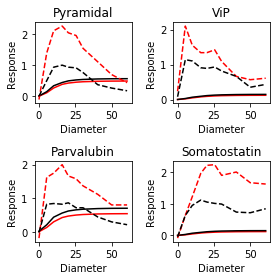

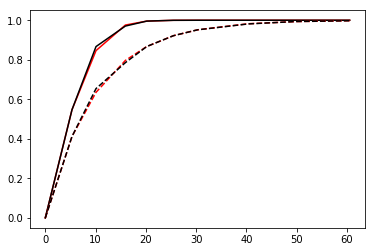

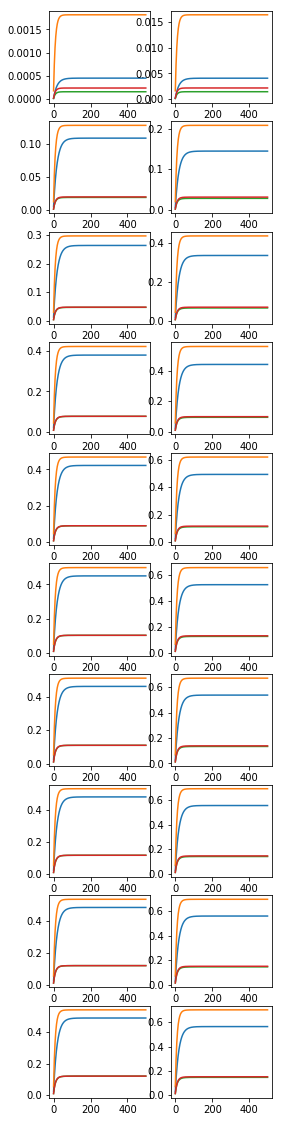

In [12]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

responses,latin,ffin,ww = sess.run([states,lat_input(input_size),
                                              ff_input(input_size),W],{input_arousal:data_arousal,input_size:data_stim_size})

print(ww)
OUT = np.mean(np.reshape(responses[:,-test_nt:],[2,10,-1,4]),axis = 2)
print(OUT.shape)
true_resp = np.reshape(data_response,[2,10,4])

latin = np.reshape(latin,[2,10])
ffin = np.reshape(ffin,[2,10])

import matplotlib.pyplot as plt

fig,sub = plt.subplots(2,2,figsize = (4,4))

for i in range(2):
    for j in range(2):
        sub[i,j].plot(data_stim_size[:10],OUT[0,:,i + 2*j],"r")
        sub[i,j].plot(data_stim_size[:10],OUT[1,:,i + 2*j],"k")
        
        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"r--")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"k--")
        sub[i,j].set_title(data_names[i+2*j])
        sub[i,j].set_xlabel("Diameter")
        sub[i,j].set_ylabel("Response")


plt.tight_layout()
plt.show()

plt.plot(data_stim_size[:10],ffin[0,:],"r")
plt.plot(data_stim_size[:10],ffin[1,:],"k")
plt.plot(data_stim_size[:10],latin[0,:],"r--")
plt.plot(data_stim_size[:10],latin[1,:],"k--")
plt.show()
sess.close()

fig,sub = plt.subplots(10,2,figsize = (4,20))

for k in range(10):
    for j in range(2):
        sub[k][j].plot(responses[k + j*10])
plt.show()

In [13]:
variables = tf.trainable_variables()
vnames = [v.name for v in variables]

print(vnames)

['feedforward_inp:0', 'lateral_inp:0', 'feedback_inp:0', 'arousal_inp:0', 'feedforward_shape_parameter:0', 'lateral_shape_parameter:0', 'k:0', 'W:0']


In [14]:
init = tf.global_variables_initializer()
#config = tf.ConfigProto(device_count = {'GPU': 1})
#sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

tl = 3000
num_steps = 1000

print("step\ttrain_loss\ttest_loss")
for k in range(num_steps):
    _,train_loss,test_eval = sess.run([train,loss,test_loss],{input_arousal:data_arousal,input_size:data_stim_size,target_rates:data_response})
    if k%10 == 0:
        print("{}\t{}\t{}".format(k,train_loss,test_eval))
    #if test_eval < tl:
    #    tl = test_eval
    goodpar = sess.run(variables)


step	train_loss	test_loss
0	0.9758963584899902	nan
10	0.8663613796234131	nan
20	0.7606677412986755	nan
30	0.6607081294059753	nan
40	0.5528414845466614	nan
50	0.4542587995529175	nan
60	0.39797723293304443	nan
70	0.3618914783000946	nan
80	0.33606818318367004	nan
90	0.31812989711761475	nan
100	0.30584716796875	nan
110	0.29689106345176697	nan
120	0.2900729179382324	nan
130	0.2847026586532593	nan
140	0.2803492248058319	nan
150	0.2767469584941864	nan
160	0.2737046480178833	nan
170	0.27108684182167053	nan
180	0.2687910199165344	nan
190	0.26673832535743713	nan
200	0.26486536860466003	nan
210	0.2631186246871948	nan
220	0.26145121455192566	nan
230	0.25981926918029785	nan
240	0.2581793963909149	nan
250	0.25648579001426697	nan
260	0.2546868920326233	nan
270	0.252722829580307	nan
280	0.2505215108394623	nan
290	0.24799682199954987	nan
300	0.24504895508289337	nan
310	0.24157482385635376	nan
320	0.23749583959579468	nan
330	0.23281678557395935	nan
340	0.22771547734737396	nan
350	0.22260212898254395	nan

In [19]:
responses = sess.run(states,{input_arousal:data_arousal,input_size:data_stim_size})

parameters = sess.run(variables)

sess.close()

RuntimeError: Attempted to use a closed Session.

(20, 500, 4)
[]
['feedforward_inp:0', 'lateral_inp:0', 'feedback_inp:0', 'arousal_inp:0', 'feedforward_shape_parameter:0', 'lateral_shape_parameter:0', 'k:0', 'W:0']


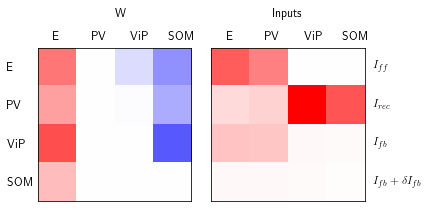

In [91]:
print(responses.shape)

print(test_indices)
print(vnames)



WW = np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]])*np.exp(parameters[-1])
inpvec = np.concatenate([[np.float32(np.array([1,1,0,0]))*np.exp(parameters[0])],[np.exp(parameters[1])],[np.exp(parameters[2])],[np.exp(parameters[3])]],axis = 0)

inpvec[-1] = inpvec[2] + (inpvec[-1] - 1)*inpvec[2]

vh = np.max(np.abs([WW,inpvec]))*.95

vl = -vh

fig,sub = plt.subplots(1,2,figsize = (5,2.5))

sub[0].matshow(WW,cmap = "bwr",vmin = vl,vmax = vh)


sub[1].matshow(inpvec,cmap = "bwr",vmin = vl,vmax = vh)

sub[1].text(1.05,.85,"$I_{ff}$",transform = sub[1].transAxes)
sub[1].text(1.05,.6,"$I_{rec}$",transform = sub[1].transAxes)
sub[1].text(1.05,.35,"$I_{fb}$",transform = sub[1].transAxes)
sub[1].text(1.05,.1,"$I_{fb} + \delta I_{fb}$",transform = sub[1].transAxes)

sub[1].text(.1,1.05,"E",transform = sub[1].transAxes)
sub[1].text(.35,1.05,"PV",transform = sub[1].transAxes)
sub[1].text(.6,1.05,"ViP",transform = sub[1].transAxes)
sub[1].text(.85,1.05,"SOM",transform = sub[1].transAxes)
sub[1].text(.4,1.2,"Inputs",transform = sub[1].transAxes,fontsize = 12)

sub[0].text(.1,1.05,"E",transform = sub[0].transAxes)
sub[0].text(.35,1.05,"PV",transform = sub[0].transAxes)
sub[0].text(.6,1.05,"ViP",transform = sub[0].transAxes)
sub[0].text(.85,1.05,"SOM",transform = sub[0].transAxes)

sub[0].text(-.2,.95-.1,"E",transform = sub[0].transAxes)
sub[0].text(-.2,.95-.35,"PV",transform = sub[0].transAxes)
sub[0].text(-.2,.95-.6,"ViP",transform = sub[0].transAxes)
sub[0].text(-.2,.95-.85,"SOM",transform = sub[0].transAxes)
sub[0].text(.5,1.2,"W",transform = sub[0].transAxes,fontsize = 12)

sub[0].set_xticks([])
sub[0].set_yticks([])

sub[1].set_xticks([])
sub[1].set_yticks([])
plt.tight_layout()
plt.savefig("./parameter_heatmap.pdf",bbox_inches = "tight")
plt.show()

In [17]:
OUT = np.mean(np.reshape(responses[:,-test_nt:],[2,10,-1,4]),axis = 2)
print(OUT.shape)
true_resp = np.reshape(data_response,[2,10,4])

(2, 10, 4)


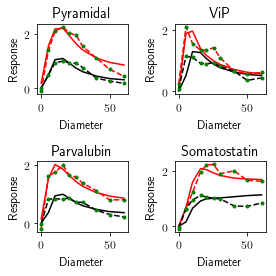

In [92]:
import matplotlib.pyplot as plt

fig,sub = plt.subplots(2,2,figsize = (4,4))

for i in range(2):
    for j in range(2):
        sub[i,j].plot(data_stim_size[:10],OUT[0,:,i + 2*j],"r")
        sub[i,j].plot(data_stim_size[:10],OUT[1,:,i + 2*j],"k")
        
        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"r--")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"k--")

        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"g.")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"g.")
        sub[i,j].set_title(data_names[i+2*j])
        sub[i,j].set_xlabel("Diameter")
        sub[i,j].set_ylabel("Response")

for i in test_indices:
    sub[i[1]%2,int(np.floor(i[1]/2))].plot(data_stim_size[i[0]%10],true_resp[int(np.floor(i[0]/10)),i[0]%10,i[1]],"b.",markersize = 10)

plt.tight_layout()
plt.savefig("./initial_multi_cell_fit.pdf",bbox_inches = "tight")
plt.show()

In [74]:
import utilities as utils 

utils.dump_file("./parameter_file",parameters)
utils.dump_file("./parameter_names",vnames)

In [75]:
parameters[-1]

array([[ 0.40361997, -4.8521132 , -0.9422726 ,  0.20026553],
       [ 0.03961628, -4.2284217 , -3.7196975 , -0.09209165],
       [ 0.670362  , -6.1046486 , -3.        ,  0.6017039 ],
       [-0.31594568, -3.        , -6.5290146 , -3.        ]],
      dtype=float32)

In [76]:
np.round(np.float32(np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]]))*np.exp(parameters[-1]),2)

array([[ 1.5 , -0.01, -0.39, -1.22],
       [ 1.04, -0.01, -0.02, -0.91],
       [ 1.95, -0.  ,  0.  , -1.83],
       [ 0.73,  0.  , -0.  ,  0.  ]], dtype=float32)

In [77]:
np.array([[1,-1,-1,-1]])*np.array([
[.017,.956,.045,.512],
[.8535,.99,.09,.307],
[2.104,.184,0,.734],
[1.285,0,.14,0]
])

array([[ 0.017 , -0.956 , -0.045 , -0.512 ],
       [ 0.8535, -0.99  , -0.09  , -0.307 ],
       [ 2.104 , -0.184 , -0.    , -0.734 ],
       [ 1.285 , -0.    , -0.14  , -0.    ]])

In [78]:
vnames

['feedforward_inp:0',
 'lateral_inp:0',
 'feedback_inp:0',
 'arousal_inp:0',
 'feedforward_shape_parameter:0',
 'lateral_shape_parameter:0',
 'k:0',
 'W:0']

In [79]:
print(np.exp(parameters[-4]))
print(np.exp(parameters[-3]))

11.298225
19.384504


In [80]:
print(np.exp(parameters[-2]))

print(data_stim_size.shape)

0.23234586
(20, 1)


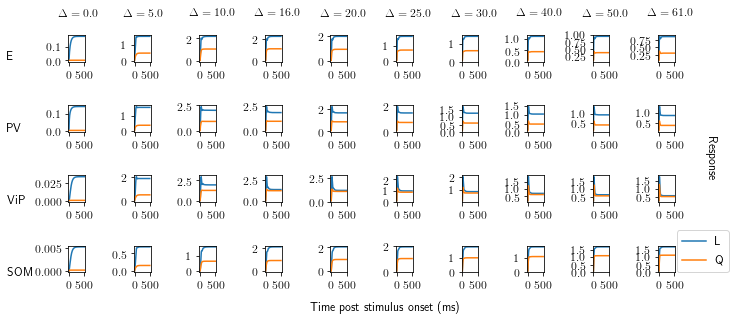

In [93]:
import matplotlib.pyplot as plt

fig,sub = plt.subplots(4,10,figsize = (10,4))

for i in range(10):
    for k in range(4):
        sub[k,i].plot(responses[i,:,k],label = "L")
        sub[k,i].plot(responses[10+i,:,k],label = "Q")

        if i == 9 and k == 3:
            sub[k,i].legend(loc = (1.1,0))
            
for k in range(10):
    fig.text(.05 + k*.091,1,"$\Delta = {}$".format(np.round(float(data_stim_size[k,0]),0)))
plt.tight_layout()

fig.text(-.02,.1,"SOM")
fig.text(-.02,.35,"ViP")
fig.text(-.02,.6,"PV")
fig.text(-.02,.85,"E")

fig.text(.4,-.02,"Time post stimulus onset (ms)")
fig.text(.95,.55,"Response",rotation = -90)
plt.tight_layout()

plt.savefig("./response_time_course.pdf",bbox_inches = "tight")
plt.show()

In [82]:
print(responses.shape)

(20, 500, 4)


In [83]:
for p in range(len(goodpar)):
    print(vnames[p])
    print(np.exp(goodpar[p]))

feedforward_inp:0
[1.7864763 1.3978367 1.        1.       ]
lateral_inp:0
[0.40588102 0.49071997 2.9622934  1.8773979 ]
feedback_inp:0
[0.6416383  0.6192416  0.07509485 0.04623587]
arousal_inp:0
[0.13451377 0.13187851 0.84408724 0.82464135]
feedforward_shape_parameter:0
11.298225
lateral_shape_parameter:0
19.384504
k:0
0.23234586
W:0
[[1.4972348e+00 7.8118518e-03 3.8974109e-01 1.2217271e+00]
 [1.0404115e+00 1.4575377e-02 2.4241300e-02 9.1202158e-01]
 [1.9549448e+00 2.2324657e-03 4.9787067e-02 1.8252261e+00]
 [7.2909904e-01 4.9787067e-02 1.4604443e-03 4.9787067e-02]]
